In [ ]:
# %% Load data and packages

from pyspark.sql import SparkSession, Row
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from prophet.utilities import regressor_coefficients



spark = SparkSession \
        .builder \
        .appName("IC2S2_Analysis") \
        .getOrCreate()

# Load Spotify data
df = spark.read.parquet('/home/mikezhu/music/data/spotify2020_preprocessed.parquet', header=True) 
print(df.count())
df.printSchema()

24/12/14 13:44:57 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
555910
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- duration: double (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
# %% vectorize features

# identify potentially relevant features and add to a feature dataframe
feature_cols = [
    #'explicit',
    #'liveness', 
    'energy',
    'loudness',
    'danceability',
    'valence',
    'tempo',
    'time_signature',
    'acousticness',
    'instrumentalness',
    'mode',
    'duration',
    'key',
    'speechiness'
]

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c) for c in feature_cols),'id') \
                         .dropna()

df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()

DataFrame[features: vector]

In [ ]:
# %% PCA functions

def find_optimal_pca_components(features,threshold=0.95,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        optimal_n: Optimal number of components
        optimal_explained_variances: Array of explained variance ratios
        optimal_cumulative_variance: Array of cumulative explained variance ratios
        model: Trained PCA model
        pca_features: DataFrame with PCA-transformed feature vectors
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_features = model.transform(features) \
                        .select('pcaFeatures')
    
    optimal_explained_variances = explained_variances[:optimal_n]
    optimal_cumulative_variance = cumulative_variance[:optimal_n]

    return optimal_n, optimal_explained_variances, optimal_cumulative_variance, model, pca_features

def analyze_pca_composition(model_pca, feature_cols):
    """
    Analyze and visualize the composition of a trained PCA model using heatmap
    
    Args:
        model_pca: Trained PCA model
        feature_cols: List of original feature names
    """
    # Get principal components matrix
    pc_matrix = model_pca.pc.toArray()
    n_components = pc_matrix.shape[1]
    
    # Create DataFrame with component compositions
    components_df = pd.DataFrame(
        pc_matrix,
        columns=[f'PC{i}' for i in range(n_components)],
        index=feature_cols
    )
    
    # Plot heatmap
    plt.figure(figsize=(6, 8))
    im = plt.imshow(components_df, cmap='RdBu', aspect='auto')
    plt.colorbar(im, label='Component Weight')
    
    # Add value annotations
    for i in range(len(feature_cols)):
        for j in range(n_components):
            plt.text(j, i, f'{components_df.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    # Customize plot
    plt.xticks(range(n_components), components_df.columns)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('PCA Components Composition')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    
    plt.tight_layout()
    plt.show()
    
    return components_df

24/12/14 13:45:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/14 13:45:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.2522
Cumulative explained variance: 0.2522
Component 2 explained variance: 0.1135
Cumulative explained variance: 0.3657
Component 3 explained variance: 0.0952
Cumulative explained variance: 0.4609
Component 4 explained variance: 0.0865
Cumulative explained variance: 0.5474
Component 5 explained variance: 0.0794
Cumulative explained variance: 0.6268
Component 6 explained variance: 0.0781
Cumulative explained variance: 0.7049
Component 7 explained variance: 0.0724
Cumulative explained variance: 0.7772
Component 8 explained variance: 0.0697
Cumulative explained variance: 0.8469
Component 9 explained variance: 0.0669
Cumulative explained variance: 0.9138
Component 10 explained variance: 0.0409
Cumulative explained variance: 0.9547
Component 

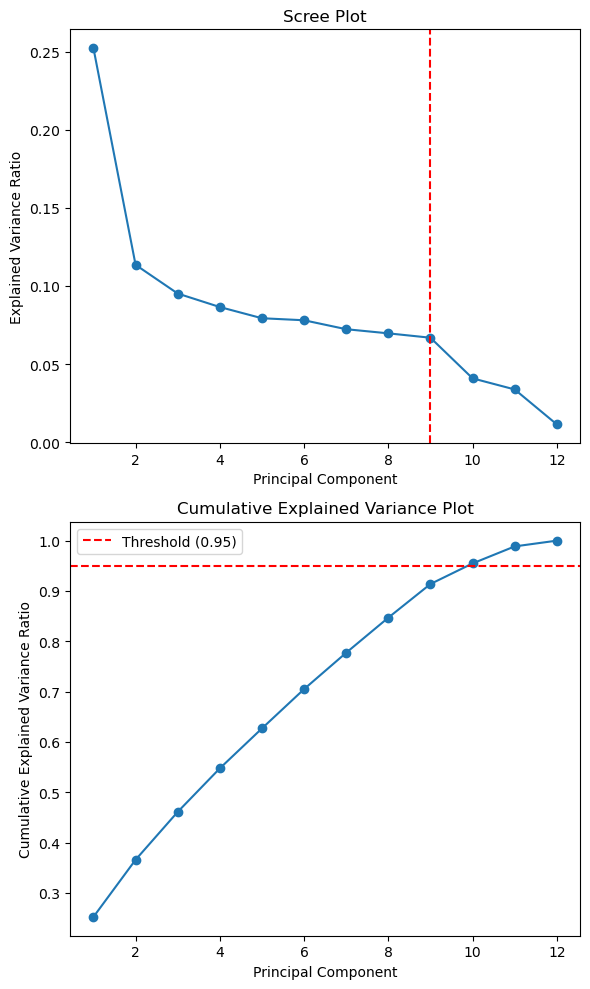

Optimal number of components: 9, threshold: 0.95


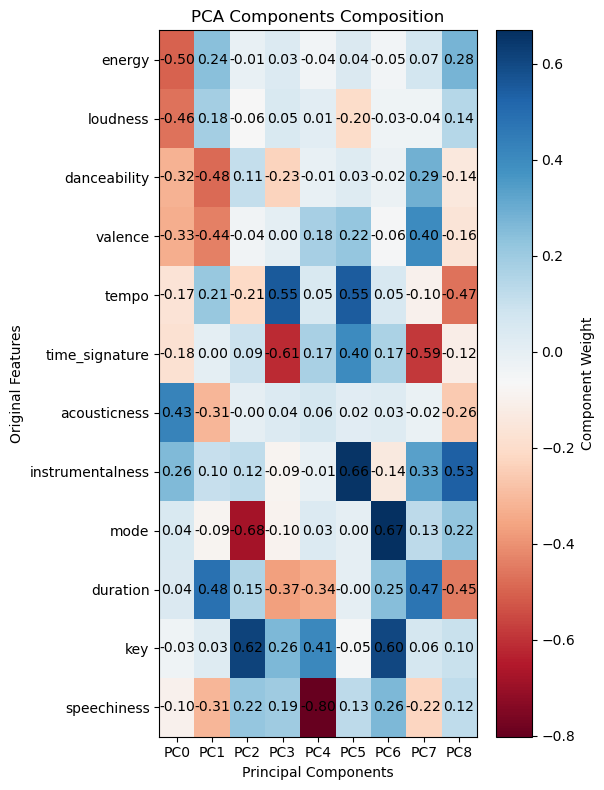

+--------------------+--------------------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------------+----+
|                  id|         pcaFeatures|            features|                name|popularity|explicit|             artists|          id_artists|release_date|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|          duration|year|
+--------------------+--------------------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------------+----+
|000mGrJNc2GAgQdME...|[0.67340790683567...|[0.15000000596046...|Symphony in B-Fla.

In [ ]:
# %% 1. PCA: find optimal number of components

optimal_n, optimal_explained_variances, optimal_cumulative_variance, model_pca, features_pca = find_optimal_pca_components(features)
components_df = analyze_pca_composition(model_pca, feature_cols)

# merge PCA results
df_pca = features_pca.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()), "tmp_id") \
            .drop("tmp_id") \
            .join(df,on=["id"],how="inner")

df_pca.show()
df_pca.count()
df_pca.printSchema()

In [ ]:
#%% time series analysis function

def calculate_centroids(df_with_array, type='cohort', window_years=5):
    """
    Calculate centroids based on specified type:
    - cohort: calculate centroids for each year separately
    - history: calculate centroids using all historical data up to each year
    - recent: calculate centroids using data from past X years (sliding window)
    
    Args:
        df_with_array: DataFrame with PCA features as arrays
        type: Type of centroid calculation ('cohort', 'history', or 'recent')
        window_years: Number of years to look back for 'recent' type (default: 5)
    """
    len_features = len(df_with_array.select('pca_array').first()[0])
    if type == 'cohort':
        # Original cohort-based calculation
        df_centroids = df_with_array.groupBy('year').agg(
            F.array([
                F.avg(F.element_at('pca_array', i+1)).alias(f'comp_{i}')
                for i in range(len_features)  
            ]).alias('centroid')
        )
    elif type == 'history':
        # Calculate historical centroids
        years = df_with_array.select('year').distinct().orderBy('year').collect()
        historical_centroids = []
        
        for year_row in years:
            year = year_row['year']
            historical_data = df_with_array.filter(F.col('year') <= year)
            
            centroid = historical_data.agg(
                F.array([
                    F.avg(F.element_at('pca_array', i+1)).alias(f'comp_{i}')
                    for i in range(len_features)
                ]).alias('centroid')
            ).first()['centroid']
            
            historical_centroids.append((year, centroid))
        
        # Convert back to Spark DataFrame
        df_centroids = spark.createDataFrame(historical_centroids, ['year', 'centroid'])
    
    elif type == 'recent':
        # Calculate recent centroids using sliding window
        years = df_with_array.select('year').distinct().orderBy('year').collect()
        recent_centroids = []
        
        for year_row in years[window_years:]:
            year = year_row['year']
            # Filter data for past X years (exclusive of current year)
            recent_data = df_with_array.filter(
                (F.col('year') <= year) & 
                (F.col('year') >= year - window_years)
            )
            
            centroid = recent_data.agg(
                F.array([
                    F.avg(F.element_at('pca_array', i+1)).alias(f'comp_{i}')
                    for i in range(len_features)
                ]).alias('centroid')
            ).first()['centroid']
            
            recent_centroids.append((year, centroid))
        
        # Convert back to Spark DataFrame
        df_centroids = spark.createDataFrame(recent_centroids, ['year', 'centroid'])
    
    return df_centroids

# visualize centroid trajectory
def plot_centroid_trajectory(df_centroids):
    """
    Plot the trajectory of centroids over years in the first two PCA dimensions.
    Colors transition from blue (early years) to yellow (recent years).
    """
    # Convert to pandas for plotting
    centroids_pd = df_centroids.toPandas()
    
    # Extract first two dimensions from centroid arrays
    centroids_pd['x'] = centroids_pd['centroid'].apply(lambda x: x[0])
    centroids_pd['y'] = centroids_pd['centroid'].apply(lambda x: x[1])
    
    # Create color gradient based on years
    years = centroids_pd['year'].values
    min_year, max_year = years.min(), years.max()
    colors = plt.cm.viridis((years - min_year) / (max_year - min_year))
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Plot points
    plt.scatter(centroids_pd['x'], centroids_pd['y'], 
               c=colors, s=100, alpha=0.6)
    
    # Add year labels
    for i, row in centroids_pd.iterrows():
        plt.annotate(str(int(row['year'])), 
                    (row['x'], row['y']),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8)
    
    plt.xlabel('First PCA Component')
    plt.ylabel('Second PCA Component')
    plt.title('Centroid Trajectory Over Years')
    plt.grid(True, alpha=0.3)
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), 
                label='Year', 
                ticks=[0, 1],
                boundaries=np.linspace(0, 1, 100),
                values=np.linspace(0, 1, 99))
    plt.tight_layout()
    plt.show()

def plot_centroid_quiver(df_centroids):
    """
    Plot quiver diagram showing centroid movements between consecutive years.
    Arrows start from origin, colors transition from blue (early years) to yellow (recent years).
    """
    # Convert to pandas for plotting
    centroids_pd = df_centroids.toPandas()
    
    # Extract first two dimensions from centroid arrays
    centroids_pd['x'] = centroids_pd['centroid'].apply(lambda x: x[0])
    centroids_pd['y'] = centroids_pd['centroid'].apply(lambda x: x[1])
    
    # Sort by year to ensure correct order
    centroids_pd = centroids_pd.sort_values('year')
    
    # Calculate yearly movement vectors
    movement_vectors = []
    movement_years = []
    
    for i in range(1, len(centroids_pd)):
        prev_year = centroids_pd['year'].iloc[i-1]
        curr_year = centroids_pd['year'].iloc[i]
        
        # Calculate yearly movement vector
        yearly_vector = np.array([
            centroids_pd['x'].iloc[i] - centroids_pd['x'].iloc[i-1],
            centroids_pd['y'].iloc[i] - centroids_pd['y'].iloc[i-1]
        ])
        movement_vectors.append(yearly_vector)
        movement_years.append(curr_year)
    
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Create color gradient based on years
    num_years = len(movement_years)
    colors = plt.cm.viridis(np.linspace(0, 1, num_years))
    
    # Plot movement vectors from origin
    for i, vector in enumerate(movement_vectors):
        plt.quiver(0, 0, vector[0], vector[1], 
                  angles='xy', scale_units='xy', scale=1,
                  color=colors[i], alpha=0.7)
    
    # Add colorbar to show year progression
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                              norm=plt.Normalize(vmin=min(movement_years), 
                                               vmax=max(movement_years)))
    plt.colorbar(sm, label='Year')
    
    plt.xlabel('First Principal Component Change')
    plt.ylabel('Second Principal Component Change')
    plt.title('Yearly Movement Vectors in Music Style Space')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.4, 0.4)
    
    plt.tight_layout()
    plt.show()


# Create UDF for Euclidean distance calculation
@F.udf(DoubleType())
def euclidean_distance(v1, v2):
    return float(sum((a - b) ** 2 for a, b in zip(v1, v2)) ** 0.5)


def prepare_yearly_distributions(df_bin_counts):
    """
    Convert Spark DataFrame with bin counts to pandas DataFrame format for analysis.
    Expected columns: year, bin, count
    Returns pandas DataFrame with yearly distributions in wide format
    """
    # Convert to pandas
    yearly_distributions_pd = df_bin_counts.toPandas()
    yearly_distributions_pd = yearly_distributions_pd.dropna()
    
    # Filter bin_index to only include first NUM_bins bins
    yearly_distributions_pd = yearly_distributions_pd[
        yearly_distributions_pd['bin_index'].between(0, NUM_bins)
    ]
    
    # Sort by year and bin for consistency
    yearly_distributions_pd = yearly_distributions_pd.sort_values(['year', 'bin_index'])
    
    # Pivot table using distance_bin instead of bin_index
    yearly_distributions_wide = yearly_distributions_pd.pivot(
        index='year',
        columns='distance_bin',
        values='track_count'
    ).reset_index()
    
    # Rename columns for clarity
    yearly_distributions_wide.columns.name = None
    
    return yearly_distributions_wide


def plot_yearly_distributions(yearly_distributions_pd):
    plt.figure(figsize=(12, 6))
    
    # Get number of bins (excluding year column)
    n_bins = len(yearly_distributions_pd.columns) - 1
    colors = plt.cm.viridis(np.linspace(0, 1, n_bins))
    
    # Plot each distance bin as a separate line
    for i, col in enumerate(yearly_distributions_pd.columns):
        if col != 'year':
            plt.plot(yearly_distributions_pd['year'], 
                    yearly_distributions_pd[col],
                    marker='o',
                    linewidth=2,
                    color=colors[i-1],
                    label=col)  # Use actual distance range as label

    plt.xlabel('Year')
    plt.ylabel('Track Count')
    plt.title('Track Counts by Distance Range Over Years')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Distance Range')
    plt.grid(True, alpha=0.3)
    # Add gray background for 1999-2001 streaming transition period
    plt.axvspan(1999, 2001, color='lightgray', alpha=0.3, label='Streaming Transition')
    plt.tight_layout()
    plt.show()


def analyze_and_plot_regressors(yearly_distributions_pd):
    # Store results
    results = {
        'intercepts': [],
        'intercepts_lower': [],
        'intercepts_upper': [],
        'slopes': [],
        'slopes_lower': [],
        'slopes_upper': [],
        'levels': [],
        'models': []  # Add storage for model objects
    }

    # Define holidays for known events
    holidays_df = pd.DataFrame({
        'holiday': 'innovation_peak',
        'ds': pd.to_datetime(['1966-01-01', '1993-01-01']),
        'lower_window': -2,
        'upper_window': 2,
    })

    

    # Get distance bins (excluding 'year' column)
    distance_bins = [col for col in yearly_distributions_pd.columns if col != 'year']
    
    # Iterate over each distance bin
    for distance_bin in distance_bins:
        df_prophet = pd.DataFrame({
            'ds': pd.to_datetime(yearly_distributions_pd['year'].astype(str) + '-01-01'),
            'y': yearly_distributions_pd[distance_bin]
        })
        # Add streaming regressors
        df_prophet['streaming'] = (df_prophet['ds'].dt.year >= 2000).astype(int)
        df_prophet['year_since_streaming'] = (df_prophet['ds'].dt.year - 2000).clip(lower=0)
        
        # Initialize and fit Prophet model
        model = Prophet(
            mcmc_samples=500,
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=holidays_df,
            seasonality_mode='additive',
            changepoint_prior_scale=0.001,
        )
        
        # Add seasonality and regressors
        model.add_seasonality(
            name='40_year_cycle',
            period=40*365.25,
            fourier_order=3
        )
        model.add_regressor('streaming')
        model.add_regressor('year_since_streaming')

        model.fit(df_prophet)
        
        # Store model object
        results['models'].append(model)

        # Extract regressor coefficients with confidence intervals
        coef_df = regressor_coefficients(model)
        
        # Store streaming effect (intercept)
        streaming_coef = coef_df.loc[coef_df['regressor'] == 'streaming'].iloc[0]
        results['intercepts'].append(streaming_coef['coef'])
        results['intercepts_lower'].append(streaming_coef['coef_lower'])
        results['intercepts_upper'].append(streaming_coef['coef_upper'])
        
        # Store year_since_streaming effect (slope)
        slope_coef = coef_df.loc[coef_df['regressor'] == 'year_since_streaming'].iloc[0]
        results['slopes'].append(slope_coef['coef'])
        results['slopes_lower'].append(slope_coef['coef_lower'])
        results['slopes_upper'].append(slope_coef['coef_upper'])
        
        results['levels'].append(distance_bin)

    # Create visualization for each distance bin
    for i, distance_bin in enumerate(distance_bins):
        model = results['models'][i]
        
        # Make predictions
        future = model.make_future_dataframe(periods=0, freq='Y')
        future['streaming'] = (future['ds'].dt.year >= 2000).astype(int)
        future['year_since_streaming'] = (future['ds'].dt.year - 2000).clip(lower=0)
        forecast = model.predict(future)
        
        # Plot components
        fig = model.plot_components(forecast)
        fig.set_size_inches(12, 8)
        plt.suptitle(f'Model Components for Distance Range {distance_bin}')
        plt.tight_layout()
        plt.show()
        
        # Plot predictions vs actual values
        model.plot(forecast, figsize=(12, 8))
        plt.xlabel('Year')
        plt.ylabel('Track Count')
        plt.title(f'Track Count Trajectory for Distance Range {distance_bin}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Plot streaming effects with confidence intervals
    plt.figure(figsize=(12, 6))

    # Plot intercept effect with confidence interval
    plt.fill_between(results['levels'], 
                    results['intercepts_lower'], 
                    results['intercepts_upper'], 
                    alpha=0.2, 
                    color='#5185B8',
                    label='Intercept 95% CI')
    plt.plot(results['levels'], 
            results['intercepts'], 
            '#5185B8', 
            label='Streaming Intercept Effect', 
            marker='o')

    # Plot slope effect with confidence interval
    plt.fill_between(results['levels'], 
                    results['slopes_lower'], 
                    results['slopes_upper'], 
                    alpha=0.2, 
                    color='#EF8636',
                    label='Slope 95% CI')
    plt.plot(results['levels'], 
            results['slopes'], 
            '#EF8636', 
            label='Streaming Slope Effect', 
            marker='o')

    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Distance Range')
    plt.ylabel('Coefficient Value')
    plt.title('Streaming Effects Across Distance Ranges with 95% Confidence Intervals')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results

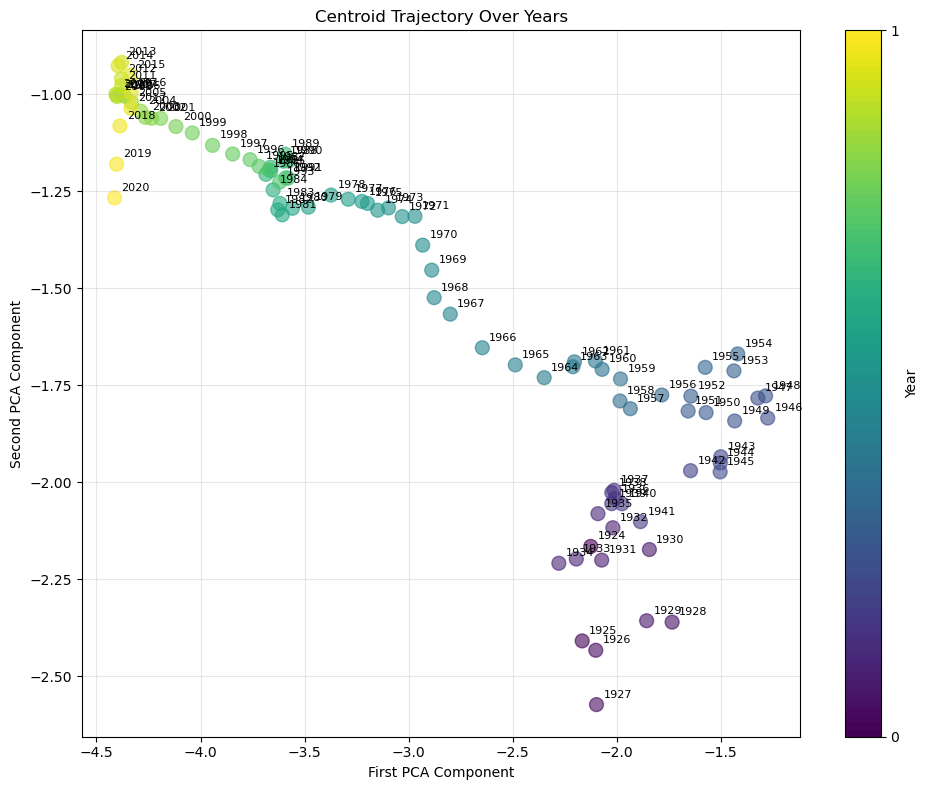

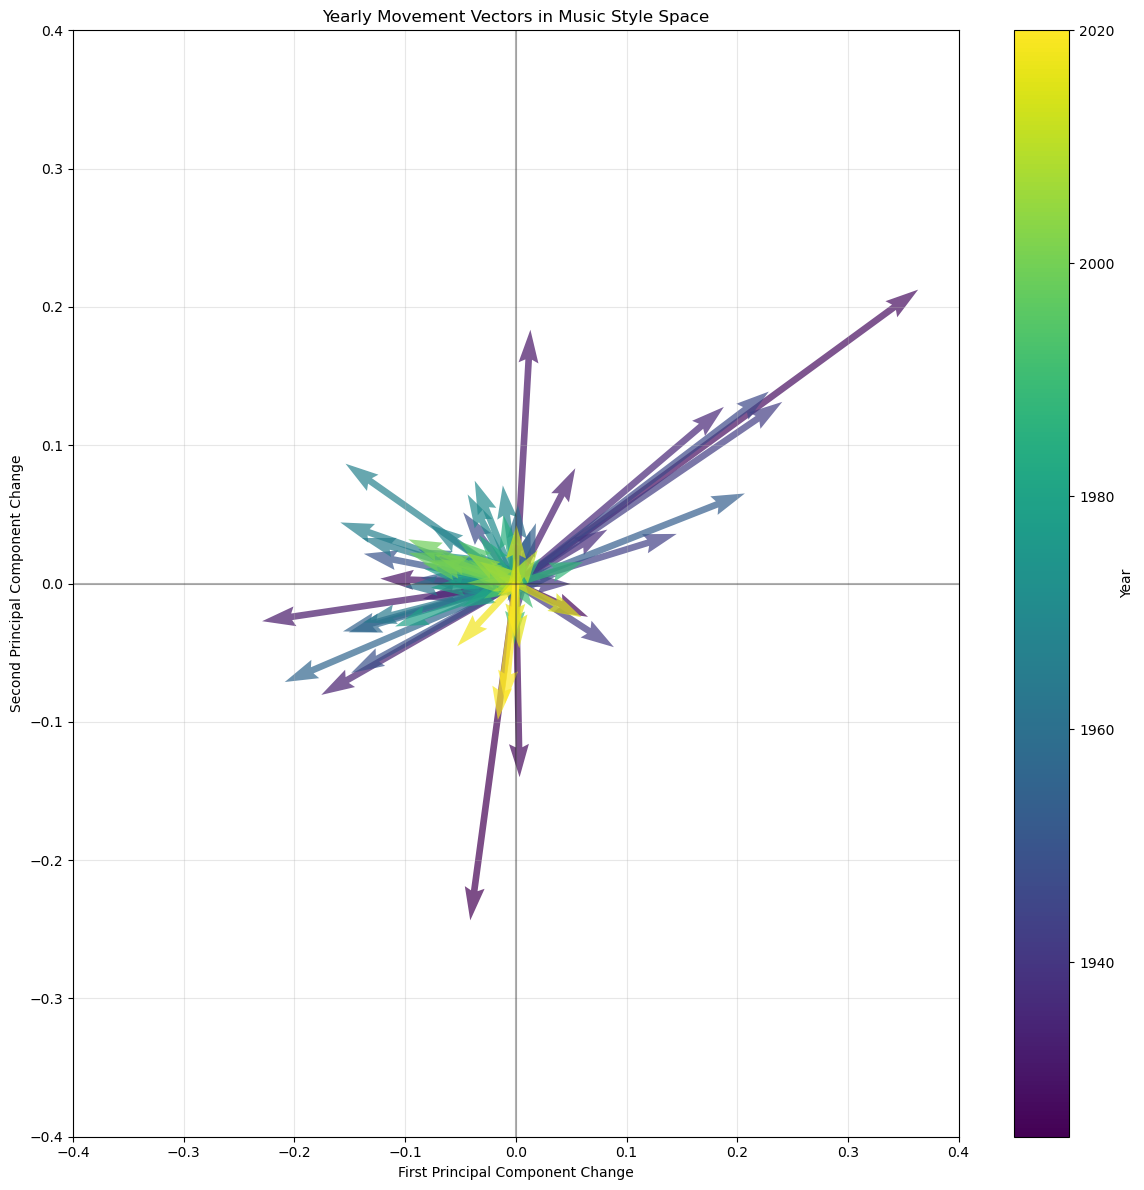

In [ ]:
# %% 1. Calculate centroids for each year

window_spec = Window.partitionBy('year')

# Convert pcaFeatures to array type for calculations
df_with_array = df_pca.withColumn('pca_array', F.udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))('pcaFeatures'))

df_centroids = calculate_centroids(df_with_array, type='recent',window_years=2) 

# Plot the centroid trajectory
plot_centroid_trajectory(df_centroids)
# Plot the centroid quiver
plot_centroid_quiver(df_centroids)

In [ ]:
# %% 2. Calculate distances

df_distance = df_with_array.join(df_centroids, on='year') \
    .withColumn('distance_to_centroid', euclidean_distance('pca_array', 'centroid'))

df_distance.orderBy('distance_to_centroid', ascending=True).show()

24/12/14 13:46:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+--------------------+--------------------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------------+--------------------+--------------------+--------------------+
|year|                  id|         pcaFeatures|            features|                name|popularity|explicit|             artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|          duration|           pca_array|            centroid|distance_to_centroid|
+----+--------------------+--------------------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--

In [ ]:
# %% 3. Create distance bins

interval_size = 1
df_distance_bin = df_distance.filter(F.col('distance_to_centroid') >= 1) \
    .withColumn(
        'distance_bin',
        F.concat(
            F.floor(F.col('distance_to_centroid') / F.lit(interval_size)) * F.lit(interval_size),
            F.lit(' - '),
            (F.floor(F.col('distance_to_centroid') / F.lit(interval_size)) + F.lit(1)) * F.lit(interval_size)
        )
    ).withColumn(
        'bin_index',
        F.floor(F.col('distance_to_centroid') / F.lit(interval_size)).cast('integer')
    )
# Show the result
df_distance_bin.select('name', 'artists', 'year', 'distance_to_centroid', 'distance_bin','bin_index').show(5)

+--------------------+--------------------+----+--------------------+------------+---------+
|                name|             artists|year|distance_to_centroid|distance_bin|bin_index|
+--------------------+--------------------+----+--------------------+------------+---------+
|Symphony in B-Fla...|['Ernest Chausson...|1951|   5.287451921321577|       5 - 6|        5|
|         El Pajarito|   ['Los Graduados']|1977|   2.862611979083908|       2 - 3|        2|
|  Als Je Bij Me Bent|     ['Andre Hazes']|1990|  2.1452249560609227|       2 - 3|        2|
|Njattu Velakkiliy...|['M. G. Radhakris...|1993|   2.172894835673968|       2 - 3|        2|
| El Negrito Sabrosón|  ['Binomio de Oro']|1986|  3.4195206353751297|       3 - 4|        3|
+--------------------+--------------------+----+--------------------+------------+---------+
only showing top 5 rows



In [ ]:
# %% 4. Group by year and distance_bin to count tracks

df_bin_counts = df_distance_bin.groupBy('year', 'bin_index','distance_bin') \
    .agg(F.count('*').alias('track_count')) \
    .orderBy('year', 'bin_index')

# Show the results
print("Track counts by year and distance bin:")
df_bin_counts.show(20)

# Prepare data for analysis

NUM_bins=8

yearly_distributions_pd = prepare_yearly_distributions(df_bin_counts)
print(yearly_distributions_pd.head())

Track counts by year and distance bin:


+----+---------+------------+-----------+
|year|bin_index|distance_bin|track_count|
+----+---------+------------+-----------+
|1924|        1|       1 - 2|         16|
|1924|        2|       2 - 3|        231|
|1924|        3|       3 - 4|        131|
|1924|        4|       4 - 5|         20|
|1924|        5|       5 - 6|          5|
|1924|        7|       7 - 8|          5|
|1924|        8|       8 - 9|          1|
|1924|       10|     10 - 11|          4|
|1925|        1|       1 - 2|         78|
|1925|        2|       2 - 3|        361|
|1925|        3|       3 - 4|        175|
|1925|        4|       4 - 5|         37|
|1925|        5|       5 - 6|         13|
|1925|        6|       6 - 7|          7|
|1925|        7|       7 - 8|          2|
|1925|       10|     10 - 11|          1|
|1925|       11|     11 - 12|         12|
|1926|        1|       1 - 2|        100|
|1926|        2|       2 - 3|        517|
|1926|        3|       3 - 4|        248|
+----+---------+------------+-----

   year  1 - 2  2 - 3  3 - 4  4 - 5  5 - 6  6 - 7  7 - 8  8 - 9
0  1924   16.0  231.0  131.0   20.0    5.0    NaN    5.0    1.0
1  1925   78.0  361.0  175.0   37.0   13.0    7.0    2.0    NaN
2  1926  100.0  517.0  248.0   85.0    8.0    1.0    8.0    2.0
3  1927   73.0  411.0  241.0   59.0   19.0    2.0   11.0    NaN
4  1928   77.0  476.0  379.0  233.0   51.0   11.0   26.0    3.0


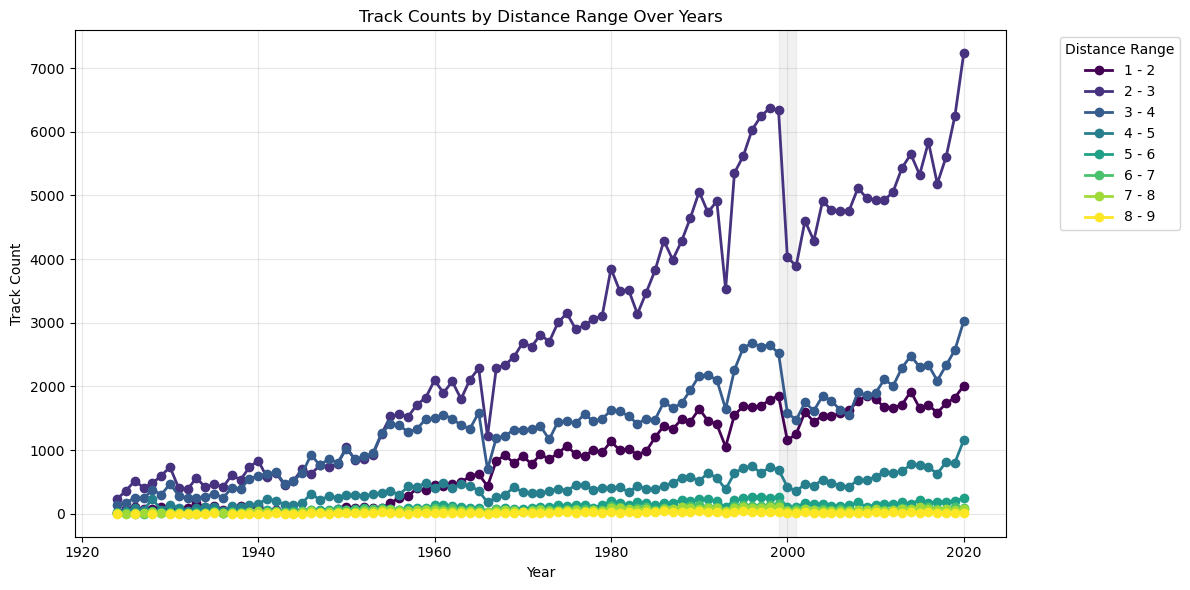

In [ ]:
# %% 5. Visualize yearly distributions

# Call the function
plot_yearly_distributions(yearly_distributions_pd)

13:46:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:06 - cmdstanpy - INFO - CmdStan done processing.
13:47:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 149 iterations at max treedepth (59.6%)
	Chain 2 had 137 iterations at max treedepth (54.8%)
	Chain 3 had 169 iterations at max treedepth (67.6%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:12 - cmdstanpy - INFO - CmdStan done processing.
13:47:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:12 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 148 iterations at max treedepth (59.2%)
	Chain 2 had 162 iterations at max treedepth (64.8%)
	Chain 3 had 159 iterations at max treedepth (63.6%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:19 - cmdstanpy - INFO - CmdStan done processing.
13:47:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 155 iterations at max treedepth (62.0%)
	Chain 2 had 145 iterations at max treedepth (58.0%)
	Chain 3 had 169 iterations at max treedepth (67.6%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:26 - cmdstanpy - INFO - CmdStan done processing.
13:47:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 157 iterations at max treedepth (62.8%)
	Chain 2 had 151 iterations at max treedepth (60.4%)
	Chain 3 had 150 iterations at max treedepth (60.0%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:32 - cmdstanpy - INFO - CmdStan done processing.
13:47:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 169 iterations at max treedepth (67.6%)
	Chain 2 had 153 iterations at max treedepth (61.2%)
	Chain 3 had 164 iterations at max treedepth (65.6%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:39 - cmdstanpy - INFO - CmdStan done processing.
13:47:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 167 iterations at max treedepth (66.8%)
	Chain 2 had 145 iterations at max treedepth (58.0%)
	Chain 3 had 151 iterations at max treedepth (60.4%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:45 - cmdstanpy - INFO - CmdStan done processing.
13:47:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 167 iterations at max treedepth (66.8%)
	Chain 2 had 151 iterations at max treedepth (60.4%)
	Chain 3 had 164 iterations at max treedepth (65.6%)
	Chain 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:52 - cmdstanpy - INFO - CmdStan done processing.
13:47:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
13:47:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 144 iterations at max treedepth (57.6%)
	Chain 2 had 160 iterations at max treedepth (64.0%)
	Chain 3 had 151 iterations at max treedepth (60.4%)
	Chain 

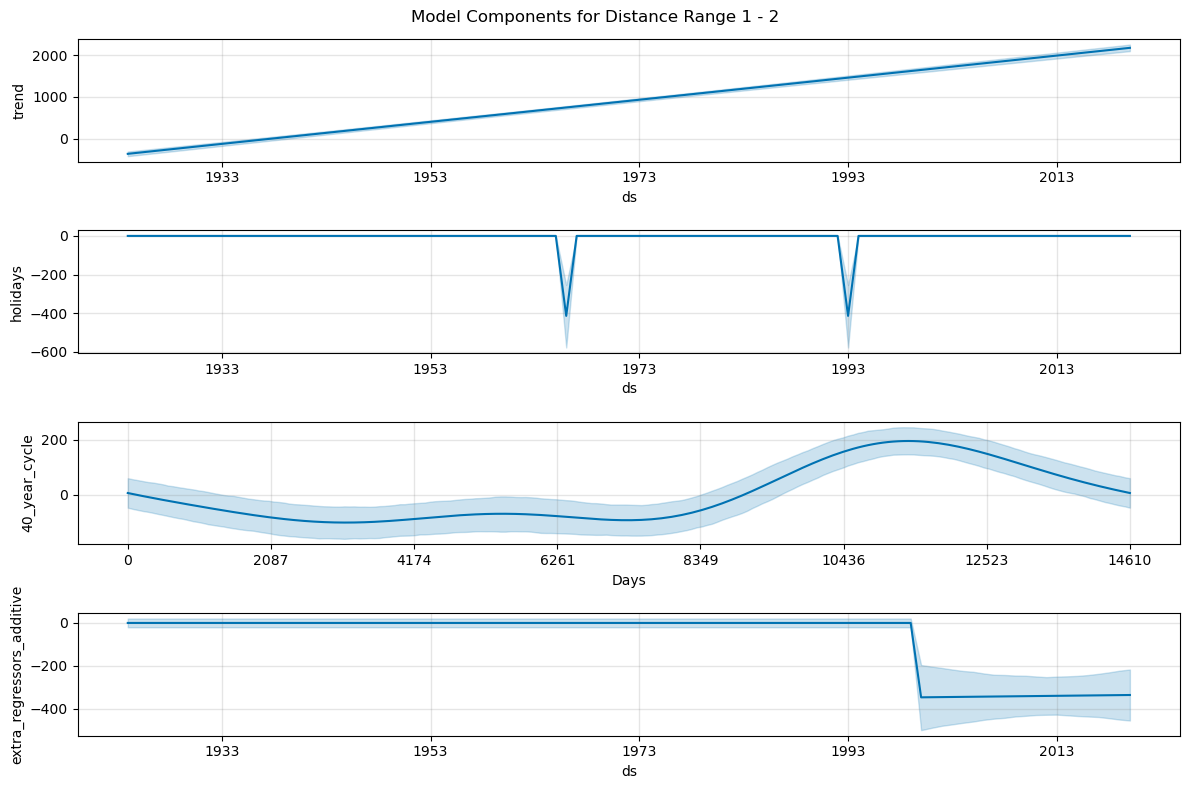

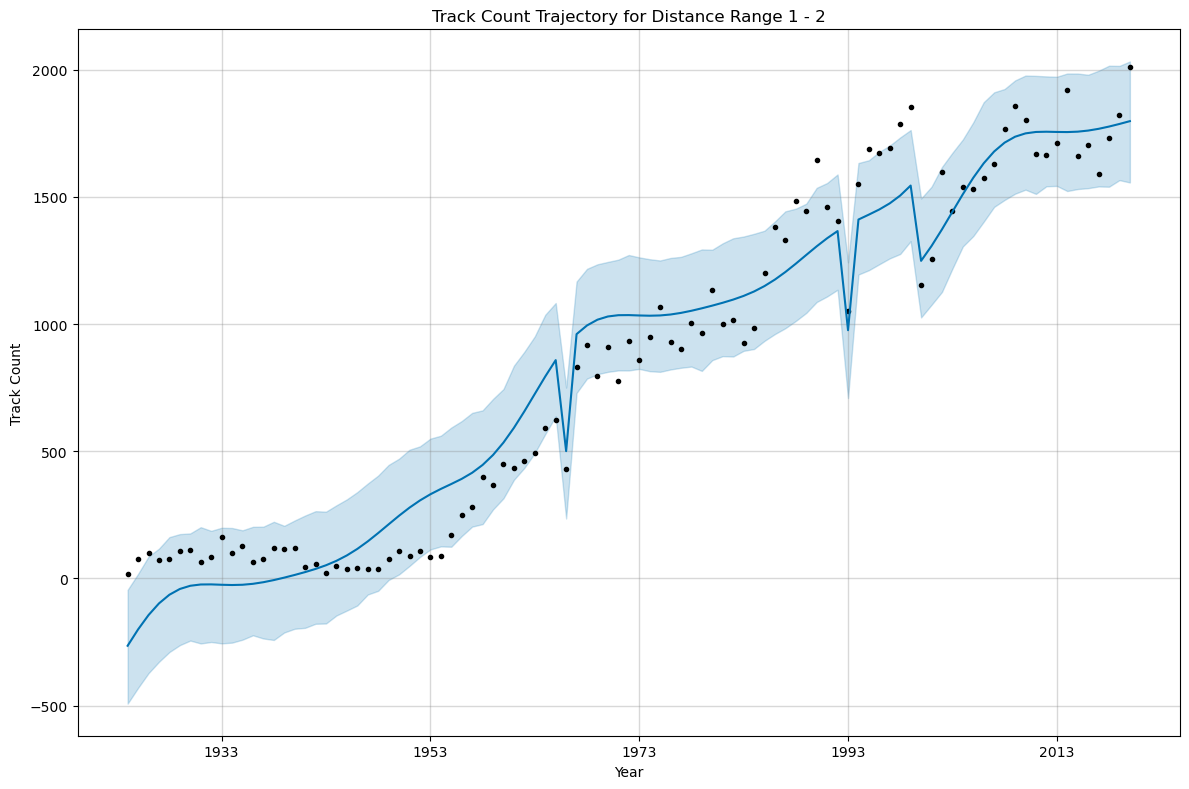

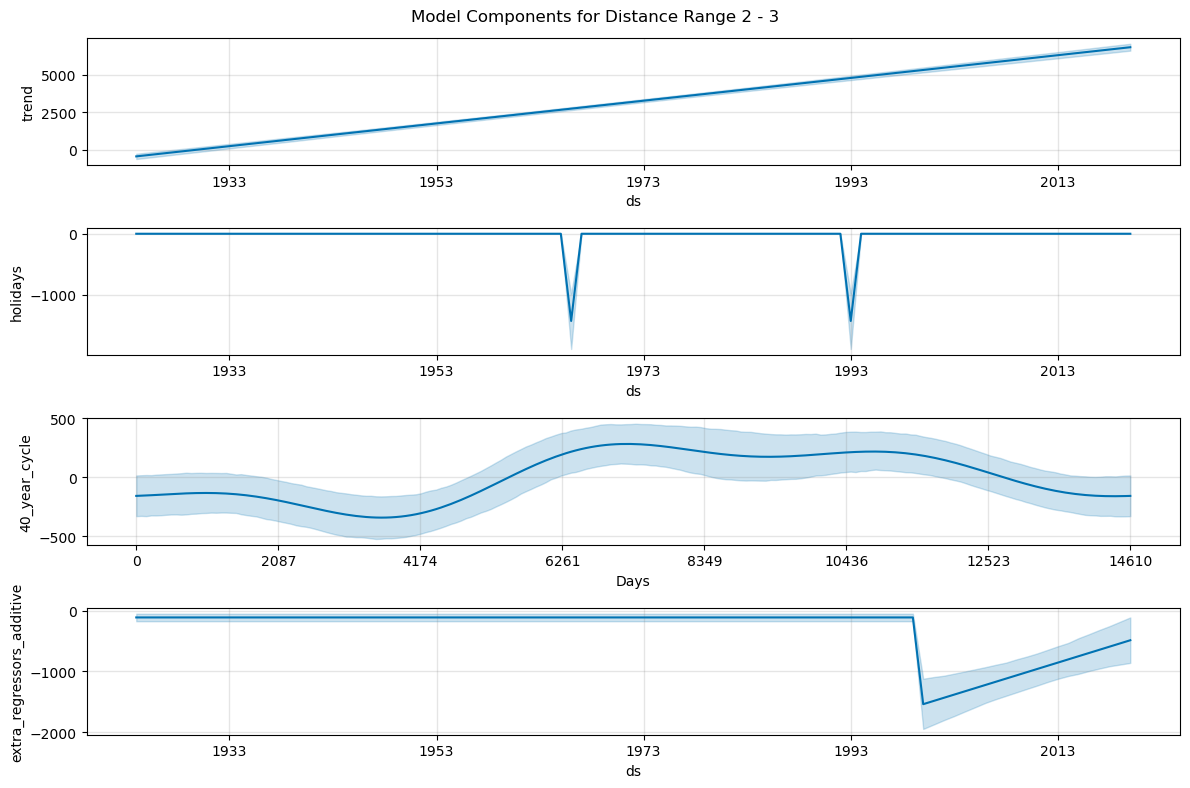

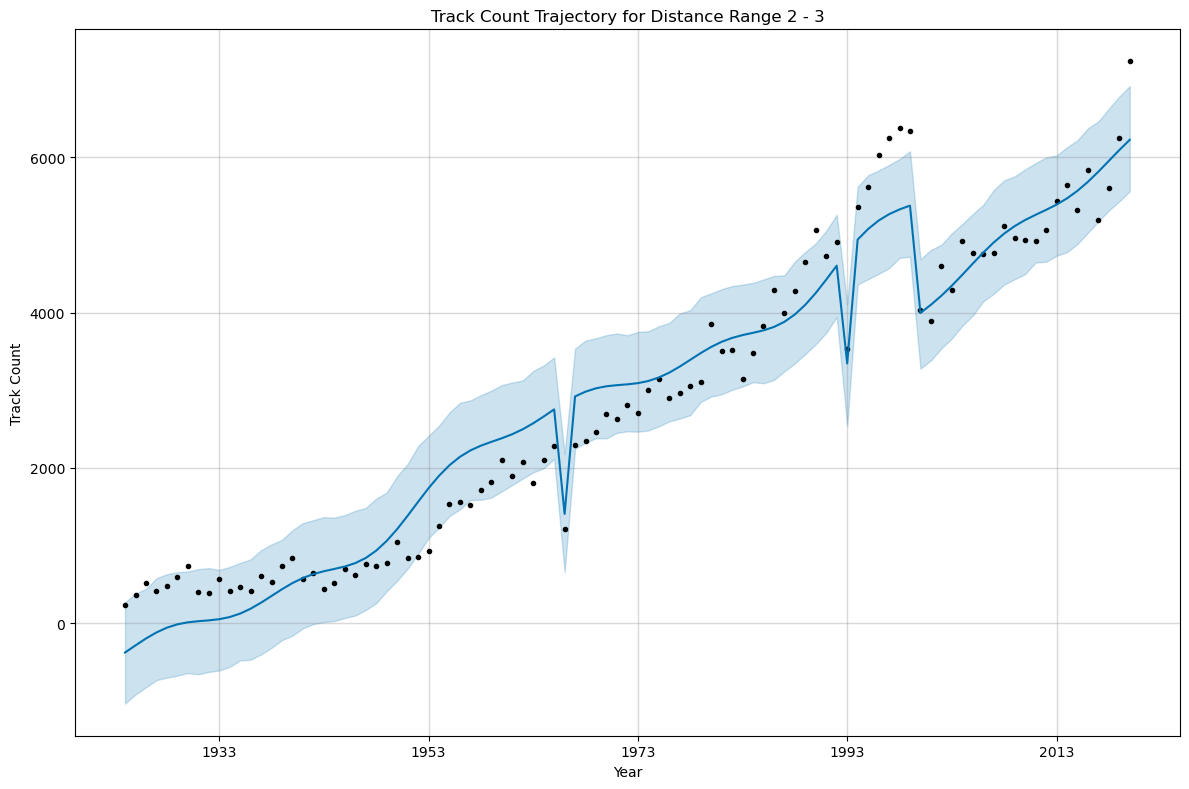

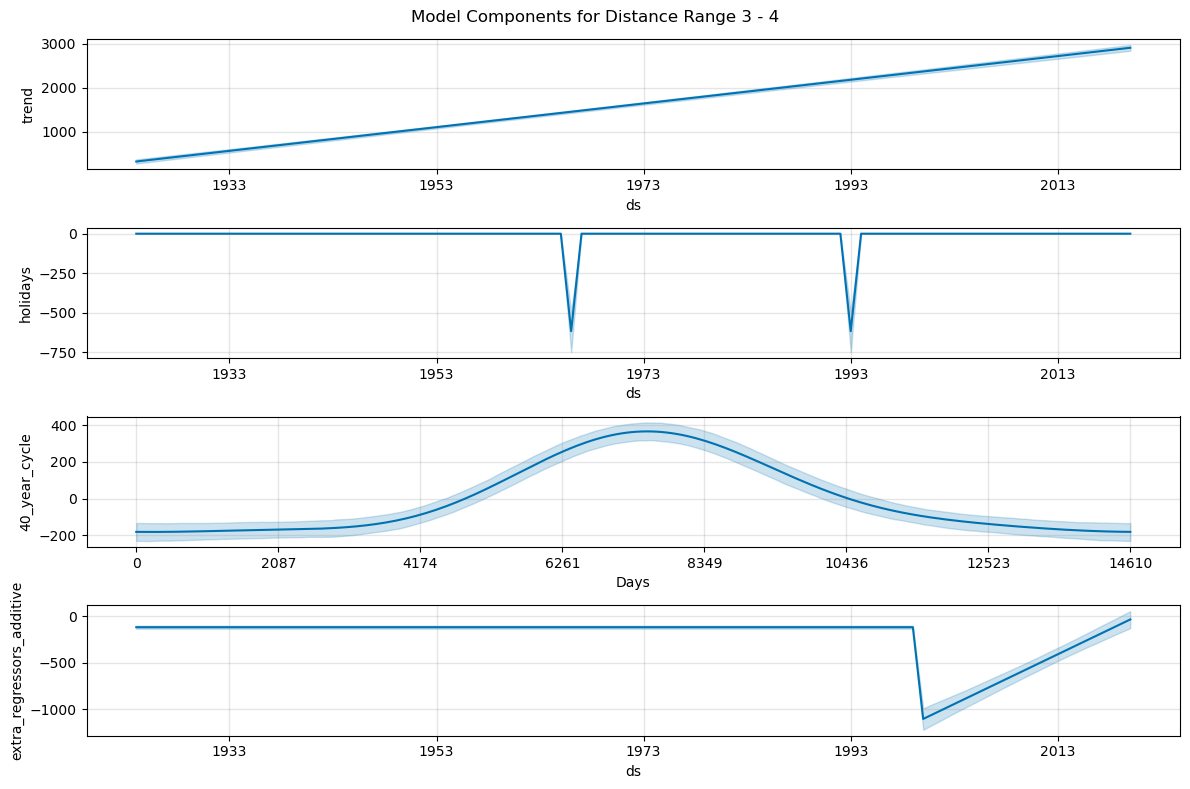

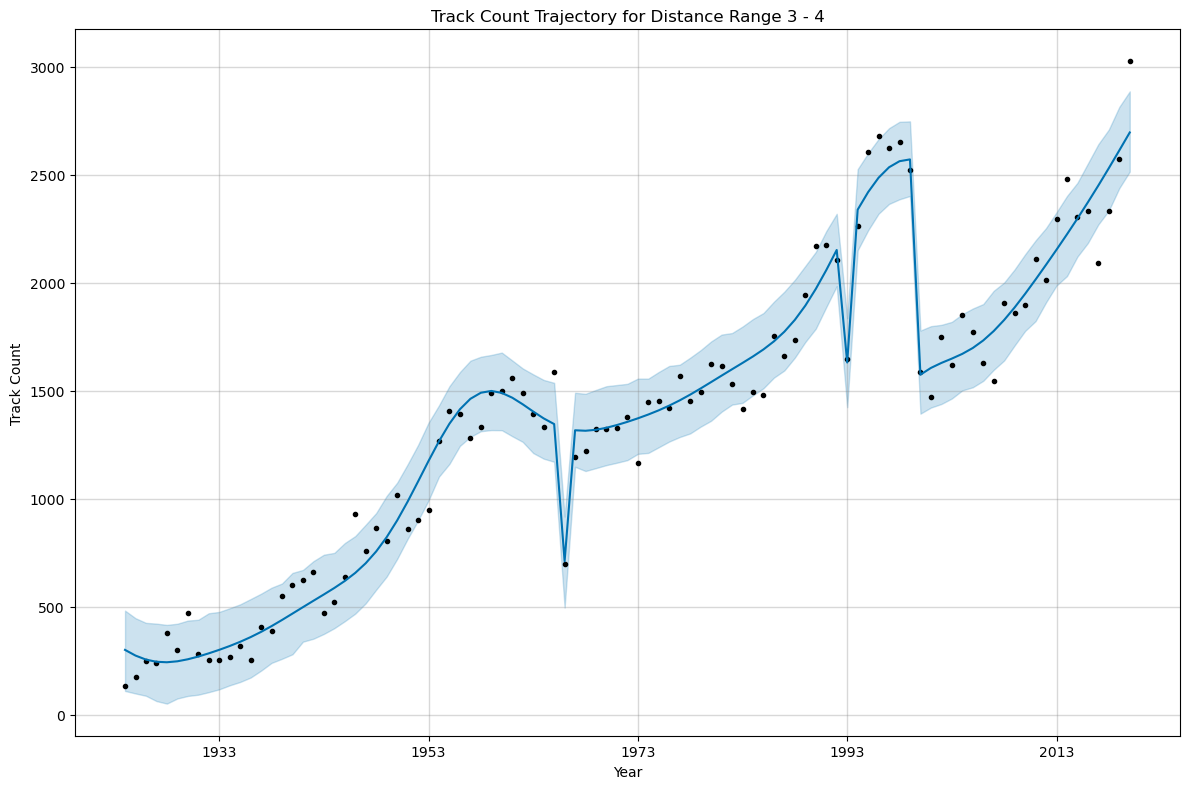

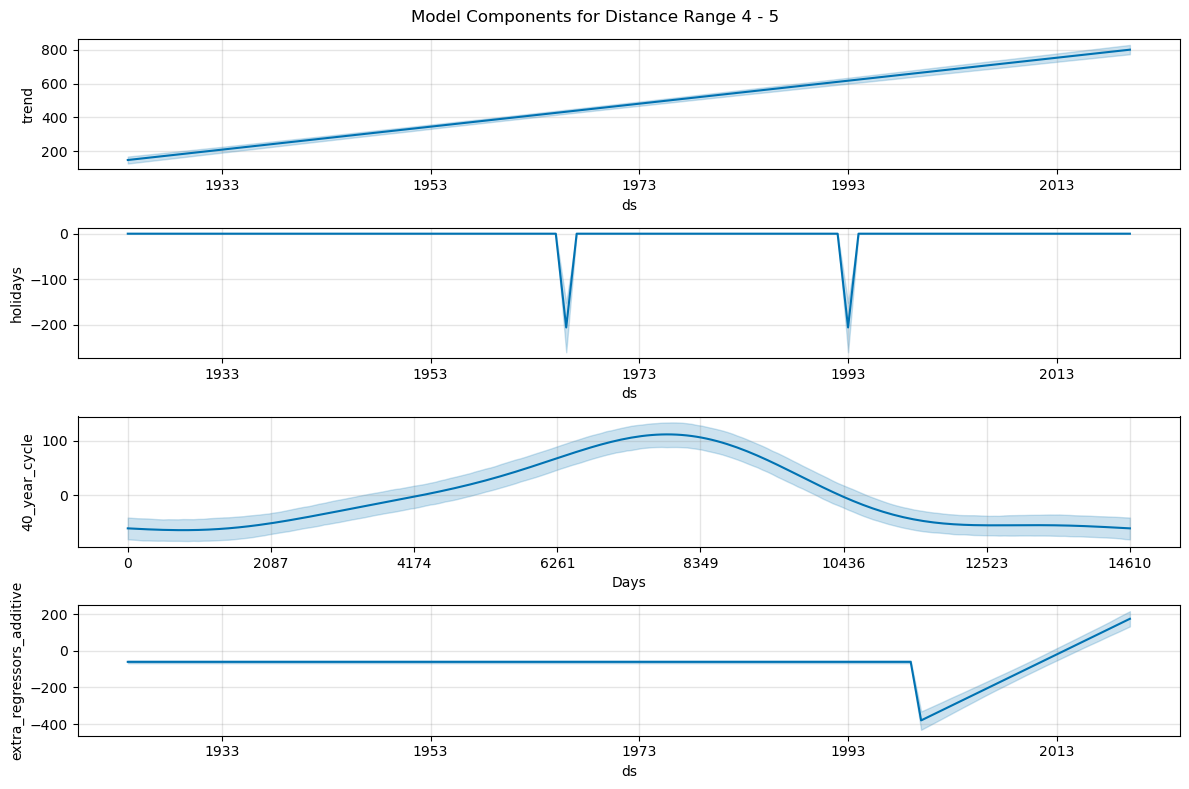

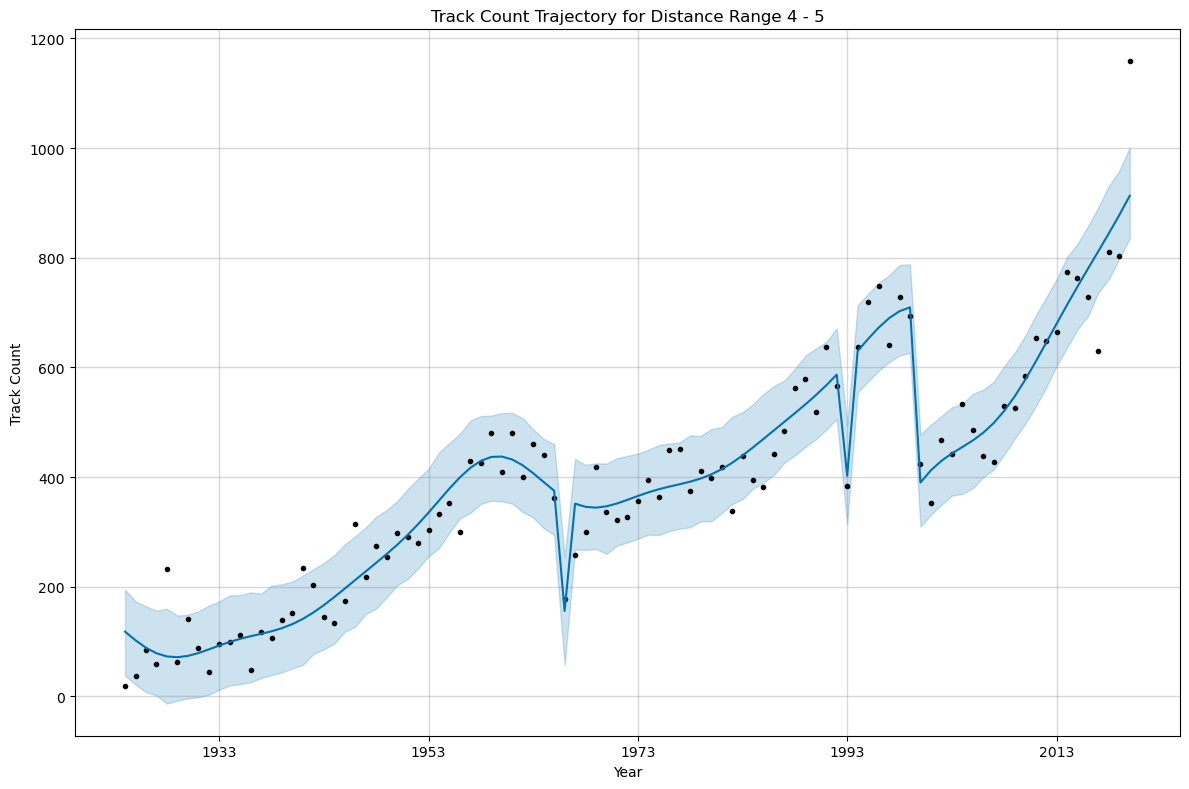

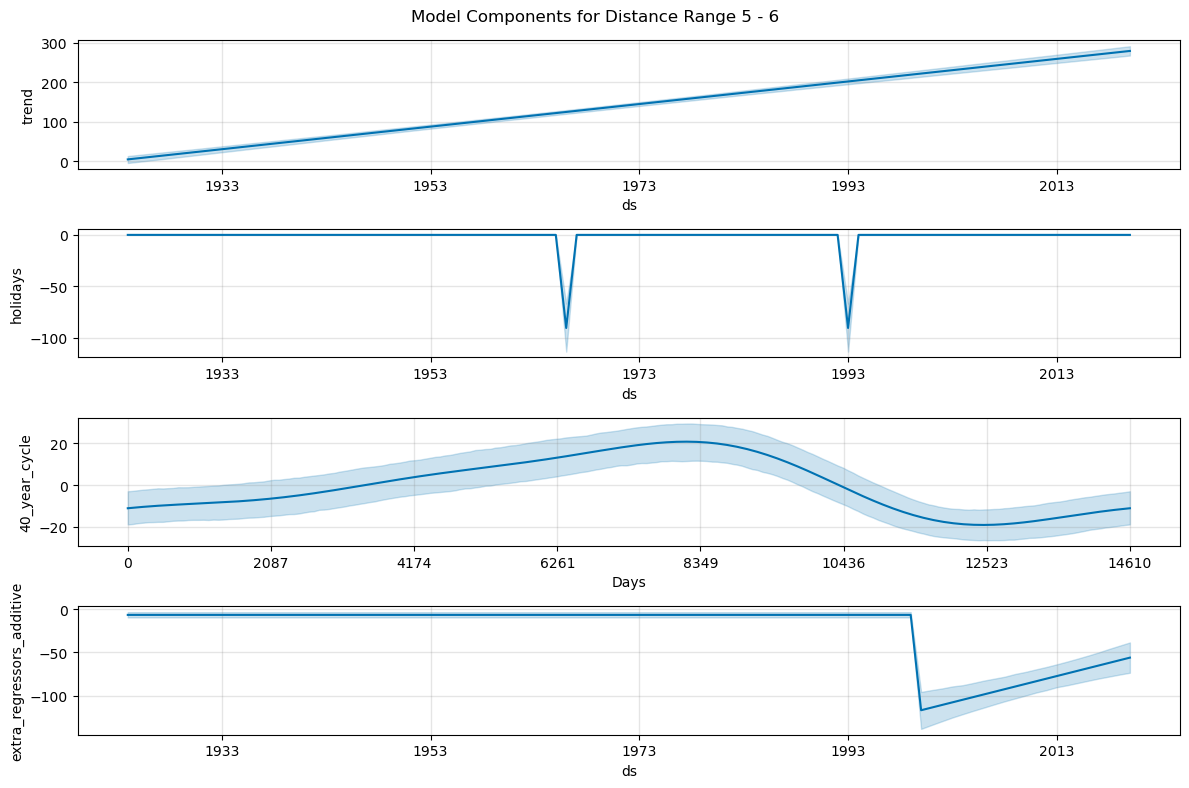

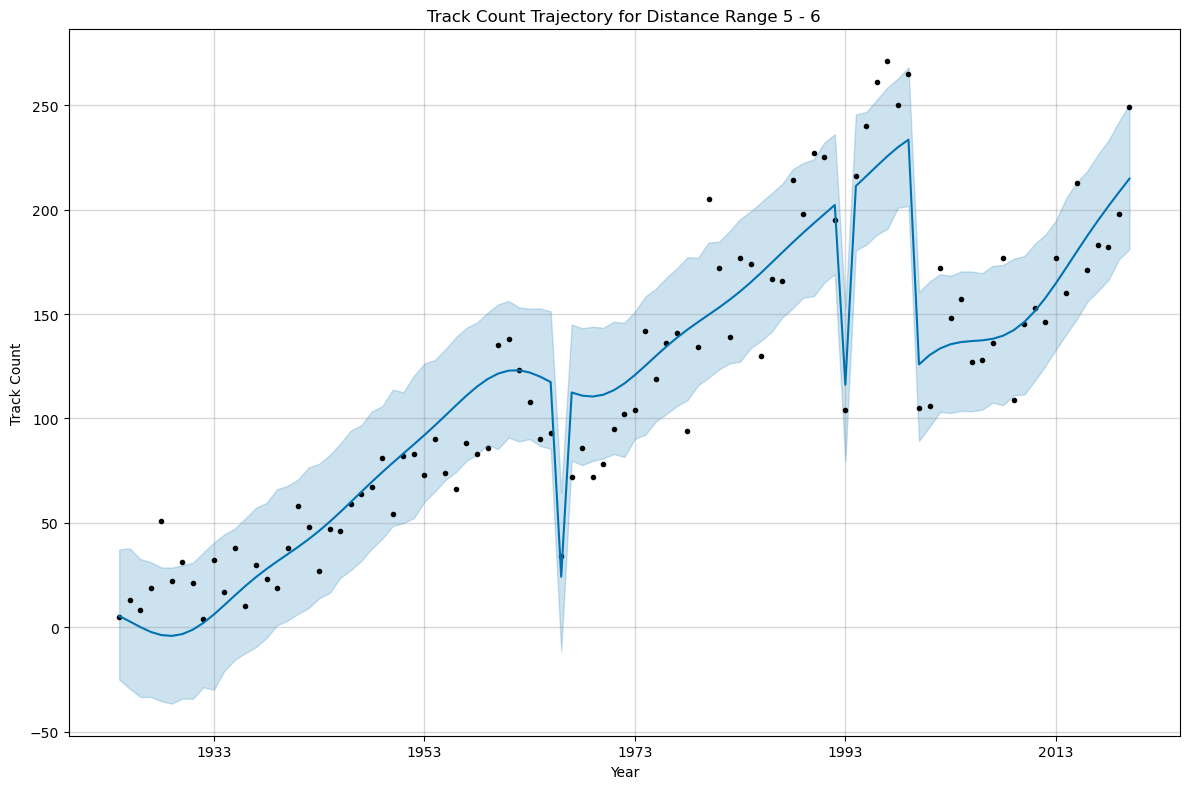

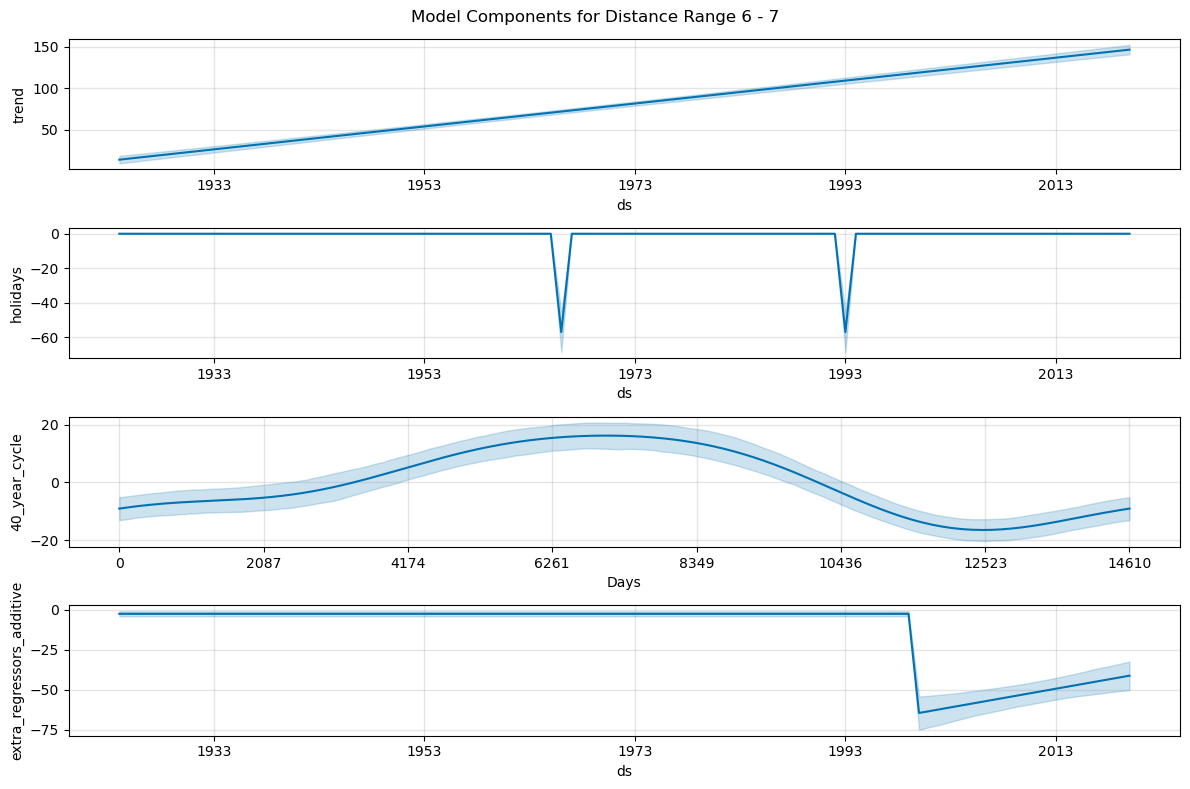

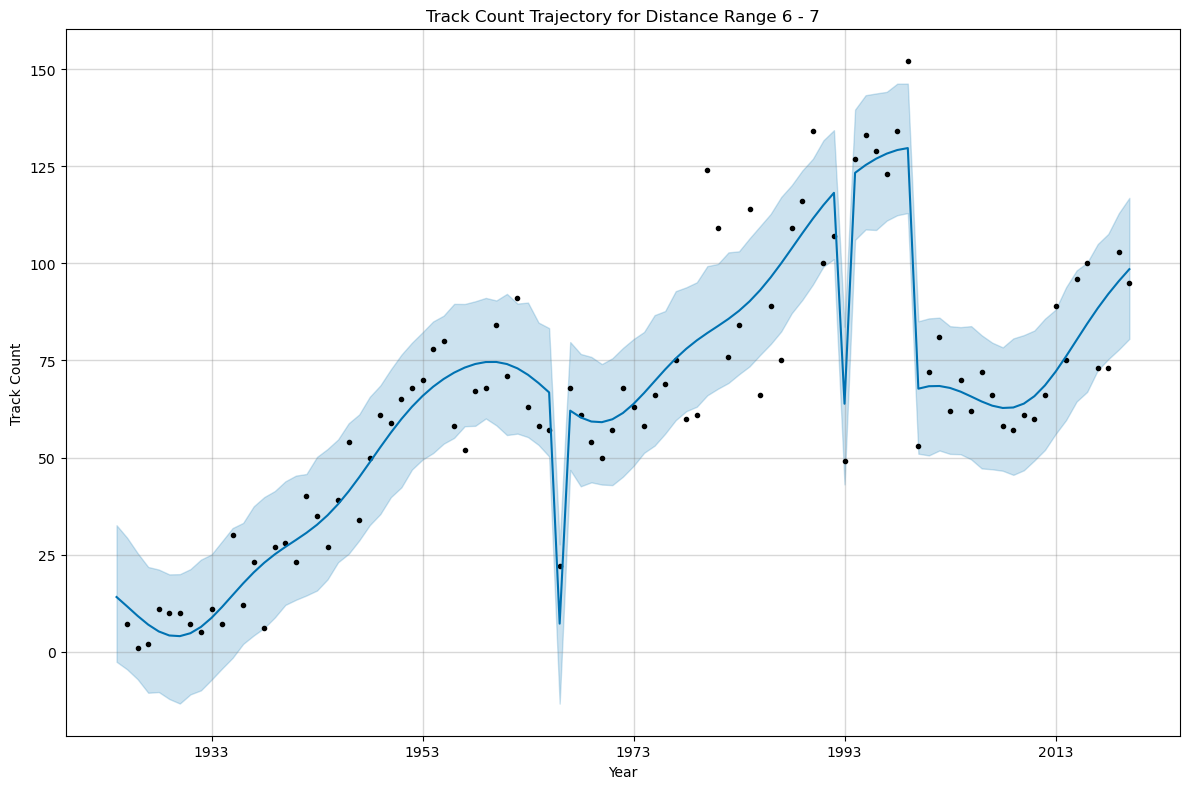

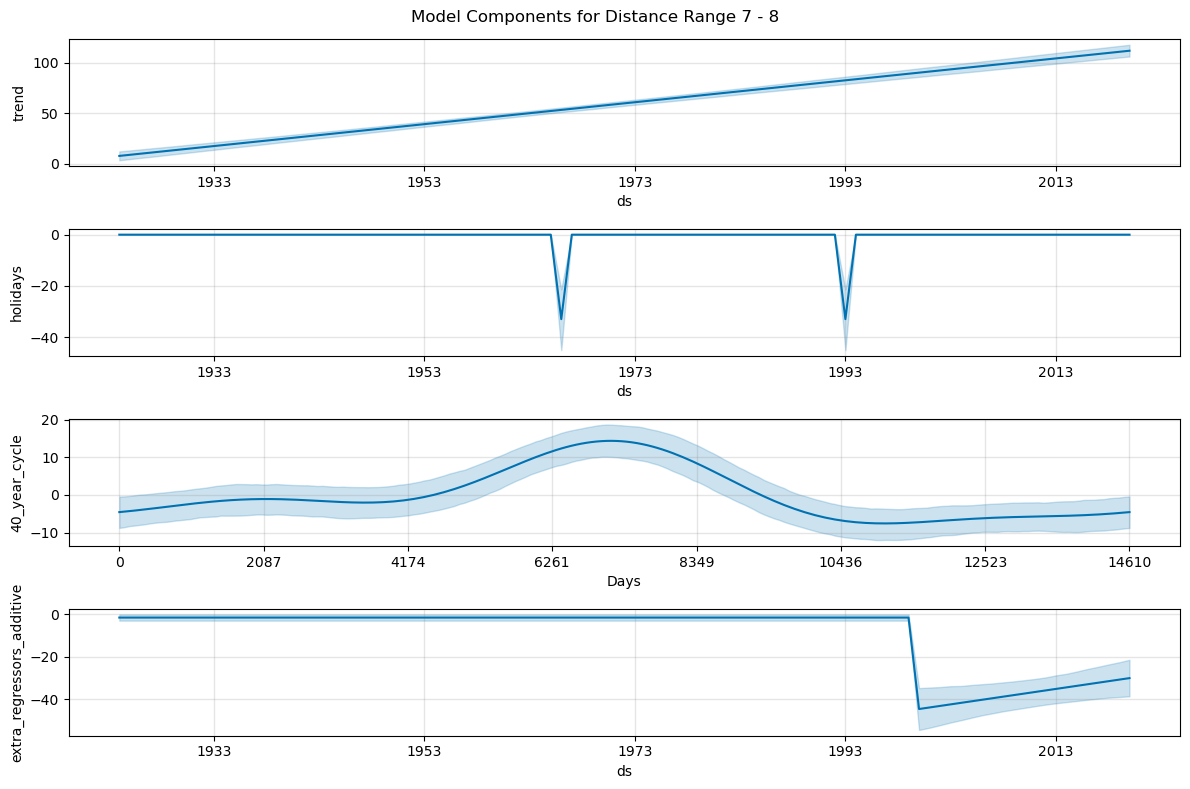

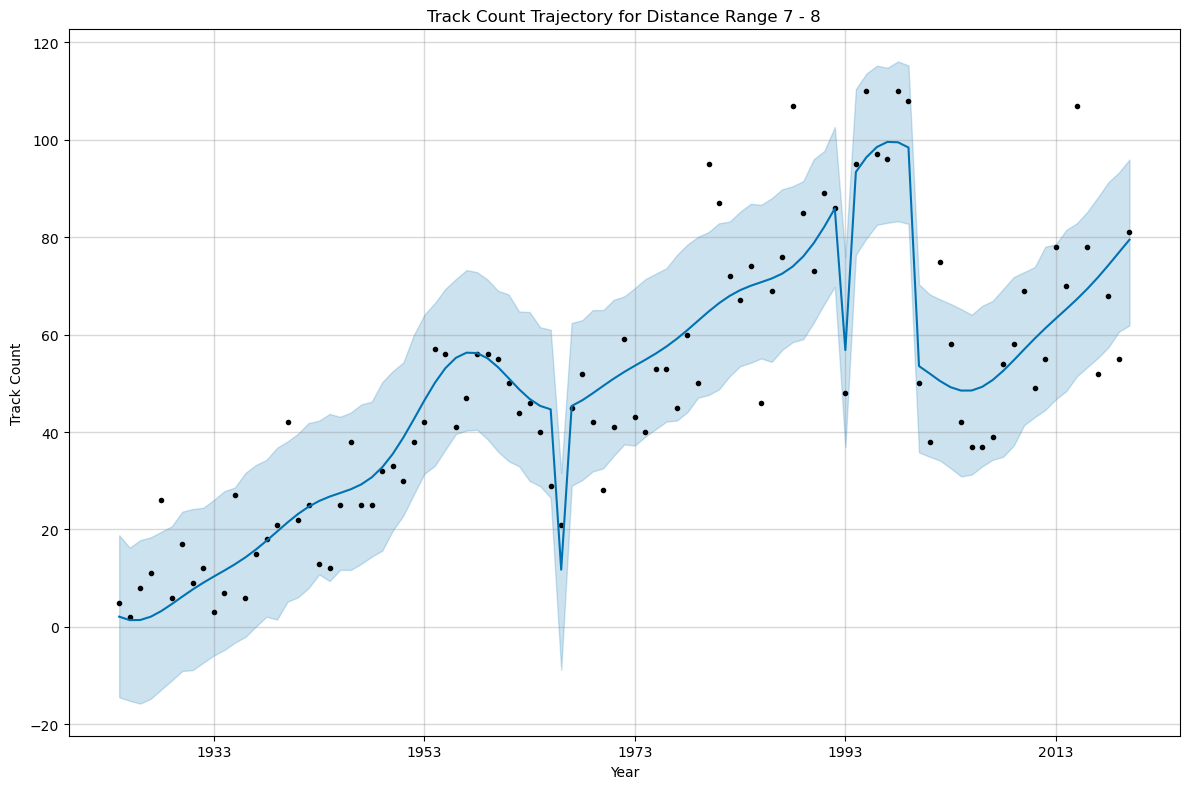

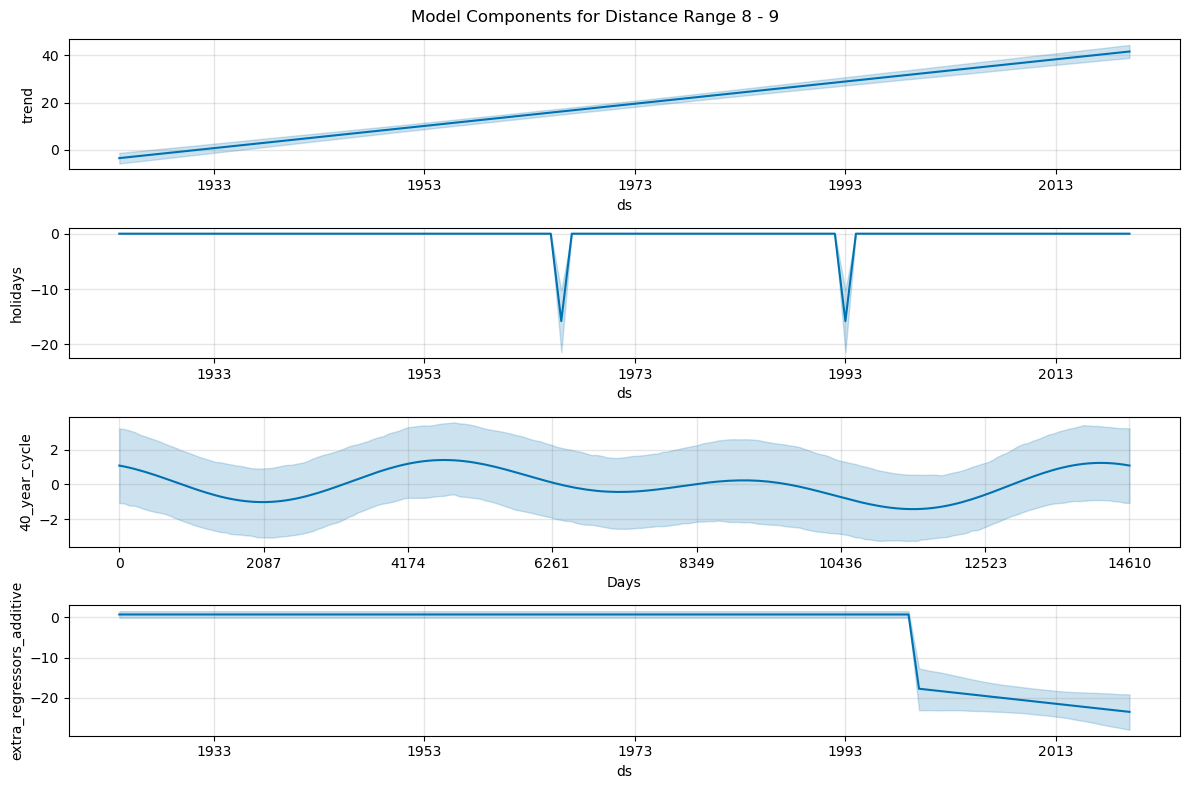

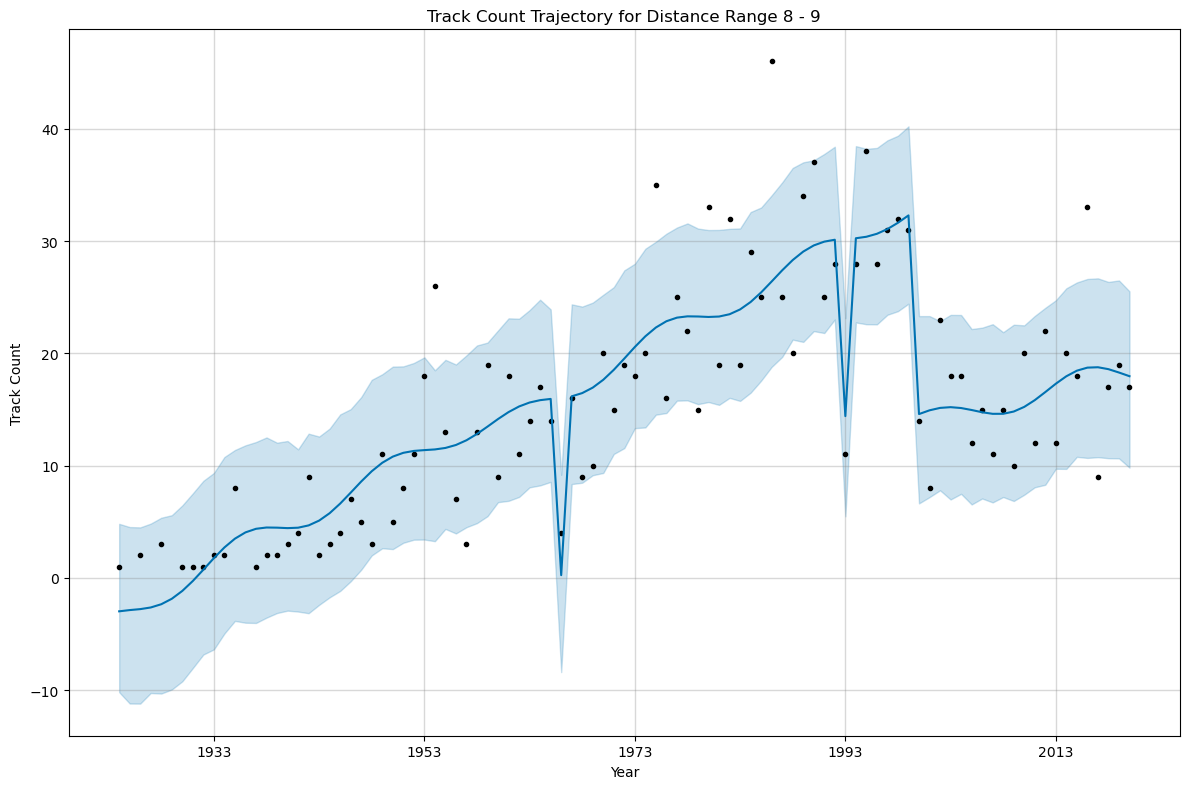

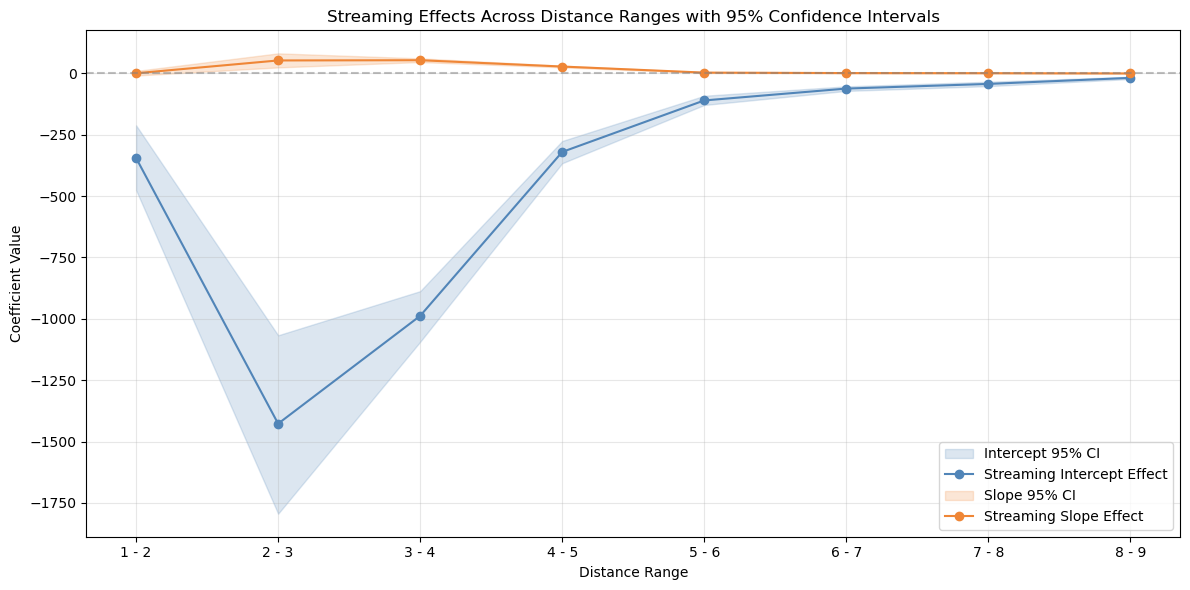

In [ ]:
# %% 6. fit Prophet model to conduct interrupted time series analysis

# Assuming yearly_distributions_pd is your prepared data
results = analyze_and_plot_regressors(yearly_distributions_pd)